In [1]:
import segmentation_models as sm
from sklearn.model_selection import train_test_split

from brainseg.generator import TrainGenerator, TestGenerator
from brainseg.loader import Loader
from brainseg.utils import load_data, show_batch_bires
from brainseg.image_provider import BiResImageHandler
from brainseg.provider import provider
from brainseg.streamlit.manager import list_all

import matplotlib.pyplot as plt
import numpy as np
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from tensorflow.keras.optimizers import Adam
from skimage.transform import resize

sm.set_framework("tf.keras")

2022-06-09 11:57:42.803430: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nathan/sandbox/elastix/elastix-5.0.1-linux/lib
2022-06-09 11:57:42.803455: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Segmentation Models: using `keras` framework.


In [2]:
from brainseg.bires_unet import bi_res_unet

In [3]:
model = bi_res_unet(n_classes=1, im_sz=224, n_channels=3, n_filters_start=32, growth_factor=1.2, upconv=True)
model.compile(
    Adam(learning_rate=1e-4),
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

2022-06-09 11:57:45.752263: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nathan/.cache/pypoetry/virtualenvs/brainseg-XuOkmMtq-py3.8/lib/python3.8/site-packages/cv2/../../lib64::/home/nathan/sandbox/elastix/elastix-5.0.1-linux/lib
2022-06-09 11:57:45.752300: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-09 11:57:45.752325: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nathan-SBRI): /proc/driver/nvidia/version does not exist


In [4]:
sh = BiResImageHandler()
provider.register(sh)

In [5]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Rot90([0, 1, 2, 3]),
])

In [6]:
def preprocess_augment(x, y):
    xa, xb = x
    xa = np.asarray(xa)
    xb = np.asarray(xb)
    y = 255 - np.asarray(y)
    
    seg = SegmentationMapsOnImage(y, shape=y.shape)
    current_seq = seq.to_deterministic()
    xa, y = current_seq(image=xa, segmentation_maps=seg)
    xb = current_seq(image=xb)
    y = 255 - y.arr
    xa = xa / 255.
    xb = xb / 255.
    y = y / 255.
    
    y = y.astype(np.float64)[:, :, :1]
    return [xa, xb], y

In [7]:
def preprocess(x, y):
    xa, xb = x
    xa = np.asarray(xa)
    xb = np.asarray(xb)
    xa = xa / 255.
    xb = xb / 255.
    y = np.asarray(y) / 255.
    y = y.astype(np.float64)[:, :, :1]
    return [xa, xb], y

In [8]:
dataset = list_all("/media/nathan/LaCie/Data/wm_x8_224_lowres//", min_threshold=10, bires=True)

In [9]:
len(dataset)

1537

In [10]:
s = list([x[1]["data_name"][:14] for x in dataset])
from collections import Counter
Counter(s)

Counter({'M148 LHRH318.c': 282,
         'M148 LHRH256.c': 302,
         'M148 LHRH260.c': 240,
         'M148 LHRH264.c': 236,
         'M148 LHRH244.c': 241,
         'M148 LHRH236.c': 236})

In [11]:
print(len(dataset))

1537


In [12]:
train_dataset, test_dataset = train_test_split(dataset, random_state=0)

In [13]:
len(train_dataset)

1152

In [14]:
train_gen = TrainGenerator(Loader(train_dataset), batch_size=4, preprocess=preprocess_augment)
test_gen = TestGenerator(Loader(test_dataset), batch_size=4, preprocess=preprocess)

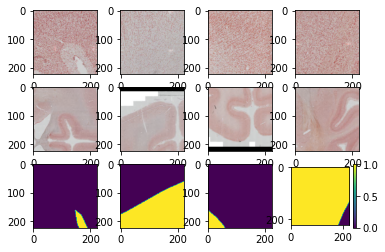

In [15]:
show_batch_bires(train_gen[0])

In [17]:
model = bi_res_unet(n_classes=1, im_sz=224, n_channels=3, n_filters_start=32, growth_factor=1.2, upconv=True)
model.compile(
    Adam(learning_rate=1e-4),
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

In [18]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_110 (Conv2D)            (None, 224, 224, 32  896         ['input_4[0][0]']                
                                )                                                           

                                                                                                  
 max_pooling2d_10 (MaxPooling2D  (None, 112, 112, 32  0          ['add_32[0][0]']                 
 )                              )                                                                 
                                                                                                  
 dropout_22 (Dropout)           (None, 112, 112, 32  0           ['max_pooling2d_15[0][0]']       
                                )                                                                 
                                                                                                  
 dropout_16 (Dropout)           (None, 112, 112, 32  0           ['max_pooling2d_10[0][0]']       
                                )                                                                 
                                                                                                  
 batch_nor

                                )                                 'batch_normalization_223[0][0]']
                                                                                                  
 add_33 (Add)                   (None, 112, 112, 38  0           ['batch_normalization_170[0][0]',
                                )                                 'batch_normalization_168[0][0]']
                                                                                                  
 leaky_re_lu_115 (LeakyReLU)    (None, 112, 112, 38  0           ['add_44[0][0]']                 
                                )                                                                 
                                                                                                  
 leaky_re_lu_87 (LeakyReLU)     (None, 112, 112, 38  0           ['add_33[0][0]']                 
                                )                                                                 
          

 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu_117 (LeakyReLU)    (None, 56, 56, 46)   0           ['batch_normalization_231[0][0]']
                                                                                                  
 leaky_re_lu_89 (LeakyReLU)     (None, 56, 56, 46)   0           ['batch_normalization_176[0][0]']
                                                                                                  
 leaky_re_lu_118 (LeakyReLU)    (None, 56, 56, 46)   0           ['leaky_re_lu_117[0][0]']        
                                                                                                  
 leaky_re_lu_90 (LeakyReLU)     (None, 56, 56, 46)   0           ['leaky_re_lu_89[0][0]']         
                                                                                                  
 batch_nor

 batch_normalization_237 (Batch  (None, 56, 56, 46)  184         ['add_46[0][0]']                 
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_184 (Batch  (None, 56, 56, 46)  184         ['conv2d_94[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_182 (Batch  (None, 56, 56, 46)  184         ['add_35[0][0]']                 
 Normalization)                                                                                   
                                                                                                  
 add_47 (Add)                   (None, 56, 56, 46)   0           ['batch_normalization_239[0][0]',
          

 Normalization)                                                                                   
                                                                                                  
 add_48 (Add)                   (None, 28, 28, 55)   0           ['batch_normalization_245[0][0]',
                                                                  'batch_normalization_243[0][0]']
                                                                                                  
 add_37 (Add)                   (None, 28, 28, 55)   0           ['batch_normalization_190[0][0]',
                                                                  'batch_normalization_188[0][0]']
                                                                                                  
 leaky_re_lu_125 (LeakyReLU)    (None, 28, 28, 55)   0           ['add_48[0][0]']                 
                                                                                                  
 leaky_re_

                                                                                                  
 leaky_re_lu_128 (LeakyReLU)    (None, 14, 14, 66)   0           ['leaky_re_lu_127[0][0]']        
                                                                                                  
 leaky_re_lu_100 (LeakyReLU)    (None, 14, 14, 66)   0           ['leaky_re_lu_99[0][0]']         
                                                                                                  
 batch_normalization_252 (Batch  (None, 14, 14, 66)  264         ['leaky_re_lu_128[0][0]']        
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_197 (Batch  (None, 14, 14, 66)  264         ['leaky_re_lu_100[0][0]']        
 Normalization)                                                                                   
          

                                                                                                  
 batch_normalization_202 (Batch  (None, 14, 14, 66)  264         ['add_39[0][0]']                 
 Normalization)                                                                                   
                                                                                                  
 add_51 (Add)                   (None, 14, 14, 66)   0           ['batch_normalization_259[0][0]',
                                                                  'batch_normalization_257[0][0]']
                                                                                                  
 add_40 (Add)                   (None, 14, 14, 66)   0           ['batch_normalization_204[0][0]',
                                                                  'batch_normalization_202[0][0]']
                                                                                                  
 max_pooli

 add_41 (Add)                   (None, 7, 7, 79)     0           ['batch_normalization_210[0][0]',
                                                                  'batch_normalization_208[0][0]']
                                                                                                  
 leaky_re_lu_135 (LeakyReLU)    (None, 7, 7, 79)     0           ['add_52[0][0]']                 
                                                                                                  
 leaky_re_lu_107 (LeakyReLU)    (None, 7, 7, 79)     0           ['add_41[0][0]']                 
                                                                                                  
 batch_normalization_266 (Batch  (None, 7, 7, 79)    316         ['leaky_re_lu_135[0][0]']        
 Normalization)                                                                                   
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_140 (Conv2D)            (None, 14, 14, 66)   39270       ['leaky_re_lu_139[0][0]']        
                                                                                                  
 batch_normalization_275 (Batch  (None, 14, 14, 66)  264         ['conv2d_140[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_273 (Batch  (None, 14, 14, 66)  264         ['leaky_re_lu_137[0][0]']        
 Normalization)                                                                                   
                                                                                                  
 add_54 (Add)                   (None, 14, 14, 66)   0           ['batch_normalization_275[0][0]',
          

 batch_normalization_288 (Batch  (None, 28, 28, 55)  220         ['conv2d_146[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu_146 (LeakyReLU)    (None, 28, 28, 55)   0           ['batch_normalization_288[0][0]']
                                                                                                  
 conv2d_147 (Conv2D)            (None, 28, 28, 55)   27280       ['leaky_re_lu_146[0][0]']        
                                                                                                  
 batch_normalization_289 (Batch  (None, 28, 28, 55)  220         ['conv2d_147[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 spose)                         )                                                                 
                                                                                                  
 concatenate_10 (Concatenate)   (None, 112, 112, 75  0           ['conv2d_transpose_8[0][0]',     
                                )                                 'add_45[0][0]']                 
                                                                                                  
 batch_normalization_300 (Batch  (None, 112, 112, 75  300        ['concatenate_10[0][0]']         
 Normalization)                 )                                                                 
                                                                                                  
 conv2d_153 (Conv2D)            (None, 112, 112, 37  25012       ['batch_normalization_300[0][0]']
                                )                                                                 
          

 conv2d_158 (Conv2D)            (None, 224, 224, 30  16770       ['batch_normalization_310[0][0]']
                                )                                                                 
                                                                                                  
 batch_normalization_311 (Batch  (None, 224, 224, 30  120        ['conv2d_158[0][0]']             
 Normalization)                 )                                                                 
                                                                                                  
 leaky_re_lu_157 (LeakyReLU)    (None, 224, 224, 30  0           ['batch_normalization_311[0][0]']
                                )                                                                 
                                                                                                  
 leaky_re_lu_158 (LeakyReLU)    (None, 224, 224, 30  0           ['leaky_re_lu_157[0][0]']        
          

In [19]:
for i in range(10):
    model.fit(train_gen, use_multiprocessing=True, workers=8)
    res = model.evaluate(test_gen)
    iou = "{:.3f}".format(res[1])
    model.save_weights(f"/media/nathan/LaCie/Data/models/model_deepres_x8_576_e{i}_iou{iou}.h5")

 43/288 [===>..........................] - ETA: 18:44 - loss: 0.8411 - iou_score: 0.6529

Process Keras_worker_ForkPoolWorker-24:
Process Keras_worker_ForkPoolWorker-22:
Process Keras_worker_ForkPoolWorker-23:
Process Keras_worker_ForkPoolWorker-18:
Process Keras_worker_ForkPoolWorker-17:
Process Keras_worker_ForkPoolWorker-21:
Process Keras_worker_ForkPoolWorker-19:
Process Keras_worker_ForkPoolWorker-20:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/pyt

KeyboardInterrupt: 

In [ ]:
res = model.evaluate(test_gen)

In [ ]:
# model.load_weights("/media/nathan/LaCie/Data/models/model_deep_x8_576_e8_iou0.793.h5")

In [ ]:
preds = model.predict(test_gen)

In [ ]:
b = test_gen[0]

len(b[0])

show_batch((b[0], preds[:4]))

In [ ]:
show_batch(b)